In [220]:
%matplotlib inline
import skimage as sk
from skimage import io
from skimage import transform
from skimage import util
from skimage import filters
from skimage import color
from skimage import feature
from skimage.feature import CENSURE

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from scipy import misc
import glob
import os
import sys
import cv2
from scipy.signal import correlate2d
from scipy import ndimage as ndi


def to_sparse(img, kernels, kwin=10, add_blobs=True, unitary=True):
    convd = []
    for k in kernels:
        filtered = ndi.convolve(img, k, mode='wrap')
        args = np.argsort(np.ravel(filtered))
        thr_idx = np.unravel_index(args[-kwin], filtered.shape)
        thr = filtered[thr_idx]
        convd.append(filtered * (filtered >= thr))
    
    if len(convd):
        convd = np.stack(convd)
        maxs = np.argmax(convd, axis=0)
        for r, row in enumerate(maxs):
            for c, img_idx in enumerate(row):
                v = convd[img_idx, r, c]
                convd[:, r, c] = 0
                convd[img_idx, r, c] = 1. if unitary else v

        convd = convd.flatten()
    
    if add_blobs:
        tmp = np.zeros_like(img)
        detected = feature.blob_dog(img, threshold=0.2, 
                            sigma_ratio=3., min_sigma=0.1, max_sigma=8)
        tmp[detected[:, 0].astype('int'), detected[:, 1].astype('int')] = 1. if unitary else detected[:, 2]

        convd = np.append(convd, tmp.flatten())
        
    return convd

48 8 6


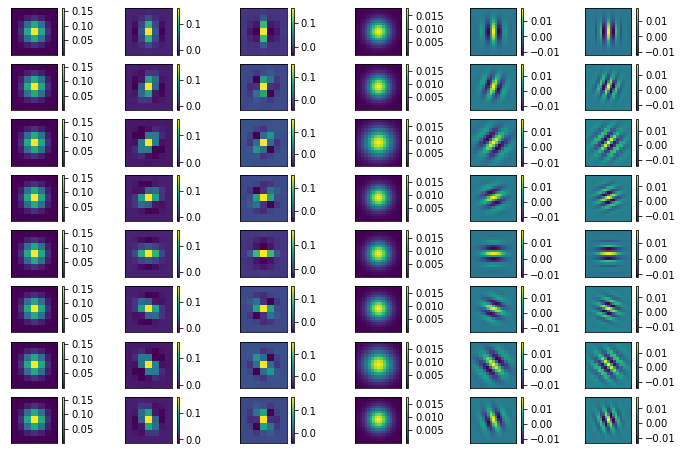

In [226]:
kernels = []
n_angs = 8
for theta in range(n_angs):
    theta = theta / n_angs * np.pi
    for sigma in (1, 3):
        for frequency in (0.01, 0.2, 0.3):
            kernel = np.real(sk.filters.gabor_kernel(
                        frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
#             print(kernel.min(), kernel.max(), kernel.sum(), (kernel**2).sum())
#             kernel = (kernel - kernel.mean()) / kernel.std()
            kernels.append(kernel)
        
n_k = len(kernels)
rows = n_angs
cols = n_k // rows + int((n_k % rows) > 0)

print(n_k, rows, cols)
plt.figure(figsize=(cols*2, rows))

for i, k in enumerate(kernels):
    ax = plt.subplot(rows, cols, i + 1)
    im = ax.imshow(k)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im)

plt.show()

In [229]:
d = 'Latin'
# d = 'Futurama'
# d = 'Braille'
# d = 'Korean'

# print(os.getcwd())
centered = bool(1)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 32
# size = 64
# size = 105
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)
small = None

expanded = {}

for i, c in enumerate(classes[:]):
    l = []
    print(c)
#     break
    files = sorted(glob.glob(os.path.join(path, c, '*.png')))
    
    for f in files:
        img = sk.color.rgb2gray(sk.io.imread(f)) == 0
        small = sk.transform.resize(img, (size, size), anti_aliasing_sigma=0.1)
        l.append(to_sparse(small, kernels, unitary=bool(0)))
#         l.append(to_sparse(small, [], unitary=bool(1)))

    expanded[i] = l

corrs = np.zeros((n_class*n_samp, n_class*n_samp))
keys = sorted(expanded.keys())
for i0, k0 in enumerate(keys):
    for i1, k1 in enumerate(keys):
        if i1 < i0:
            continue

        for j0, v0 in enumerate(expanded[k0]):
            for j1, v1 in enumerate(expanded[k1]):
                if j1 < j0:
                    continue

                w = np.sqrt(np.dot(v0, v0) * np.dot(v1, v1))
                def_v = 0. if i0 == i1 else 1.
                
                v = (np.correlate(v0, v1) / w) if w > 0 else def_v

                r = i0 * n_samp + j0
                c = i1 * n_samp + j1
                corrs[r, c] = v
                corrs[c, r] = v

                r = i0 * n_samp + j1
                c = i1 * n_samp + j0
                corrs[r, c] = v
                corrs[c, r] = v
                
# plt.figure(figsize=(10, 10))
# im = plt.imshow(corrs)
# plt.colorbar(im)
# plt.show()


14 20 280
character01
character02
character03
character04
character05
character06
character07
character08
character09
character10
character11
character12
character13
character14


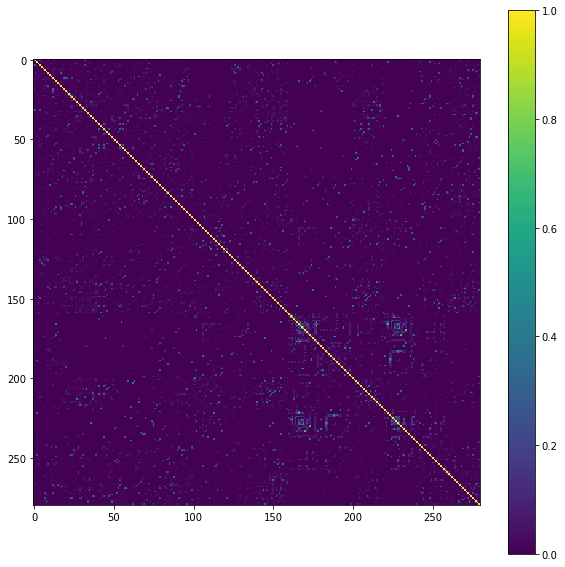

In [230]:
plt.figure(figsize=(10, 10))
im = plt.imshow(corrs)
plt.colorbar(im)
plt.show()


In [146]:

d = 'Latin'
# d = 'Futurama'
# d = 'Braille'
# d = 'Korean'

# print(os.getcwd())
centered = bool(1)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 32
# size = 64
# size = 105
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)
small = None

for i0, c0 in enumerate(classes[1:]):
    print(c0)
    files0 = sorted(glob.glob(os.path.join(path, c0, '*.png')))
    img = sk.color.rgb2gray(sk.io.imread(files0[0])) == 0
    small = sk.transform.resize(img, (size, size), order=5, anti_aliasing_sigma=0.1)
#     plt.figure()
#     plt.imshow(img)

#     plt.figure()
#     plt.imshow(small)
#     plt.show()

    break



14 20 280
character02


32 8 4


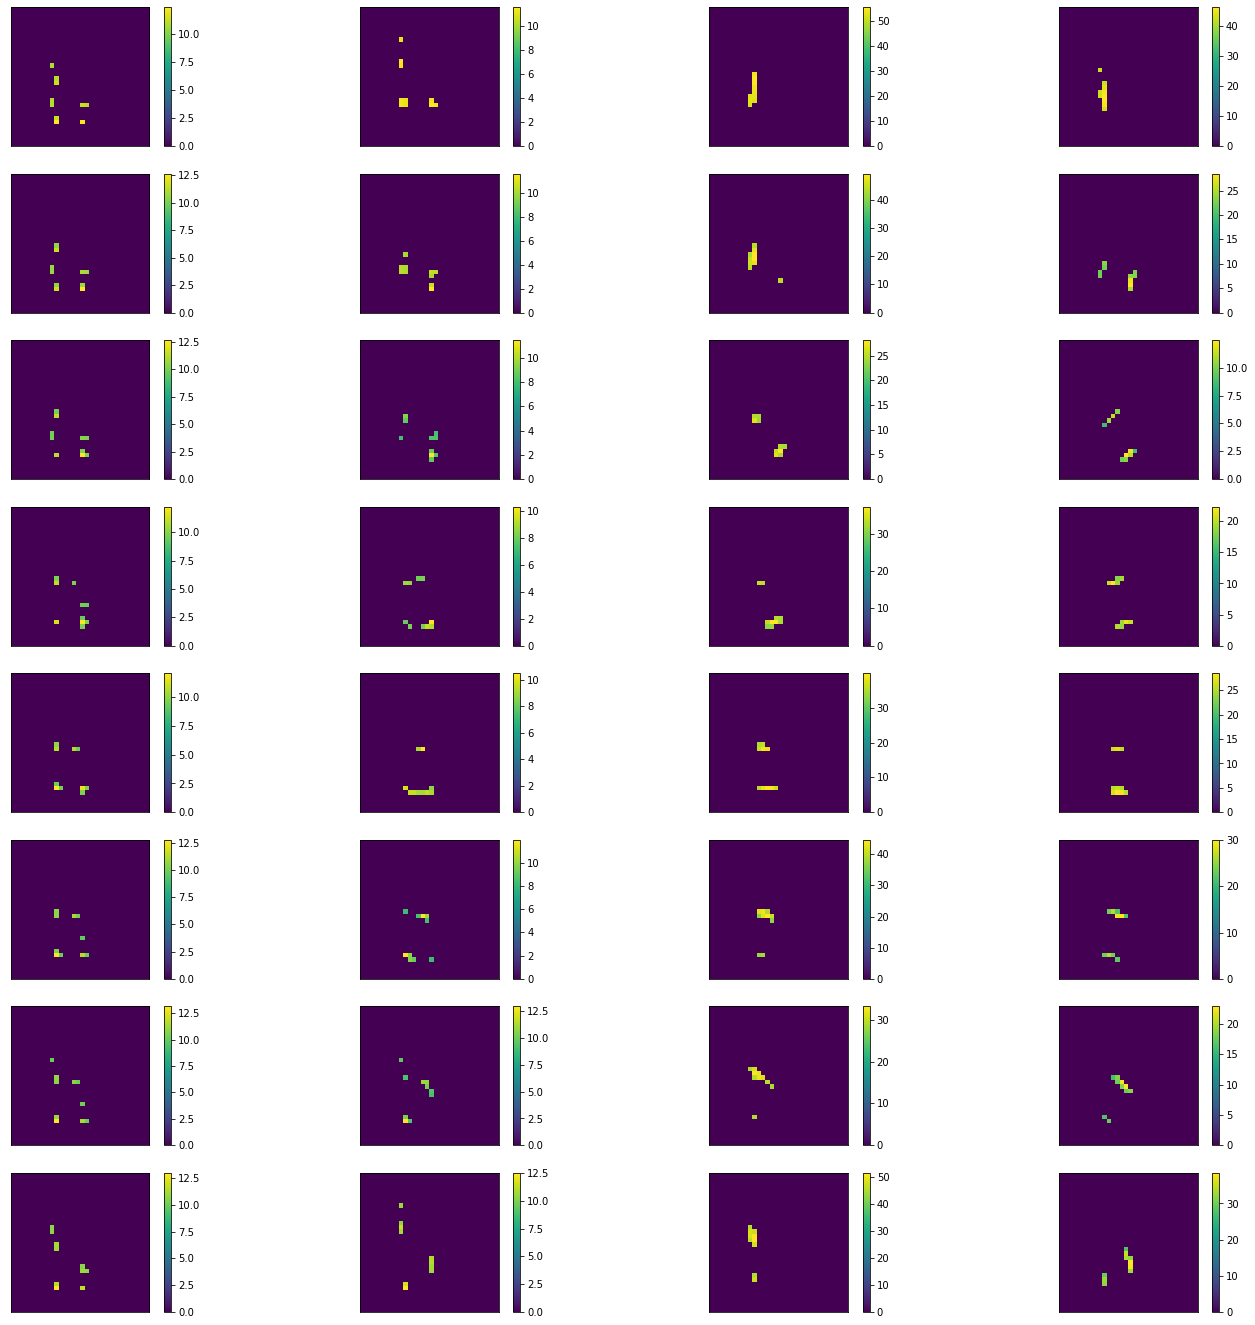

In [160]:

        

n_k = len(kernels)
rows = n_angs
cols = n_k // rows + int((n_k % rows) > 0)
fw = 3.
print(n_k, rows, cols)
plt.figure(figsize=(fw*cols*2, fw*rows))
gabored = []
for i, kernel in enumerate(kernels):
    ax = plt.subplot(rows, cols, i + 1)
    filtered = ndi.convolve(small, kernel, mode='wrap')
#     gabored.append(filtered)
    args = np.argsort(np.ravel(filtered))
    thr_idx = np.unravel_index(args[-10], filtered.shape)
    thr = filtered[thr_idx]
    gabored.append(filtered * (filtered >= thr))
    im = ax.imshow(gabored[i])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im)

plt.show()


In [161]:
gabored = np.stack(gabored)
print(gabored.shape)


(32, 32, 32)


32 8 4


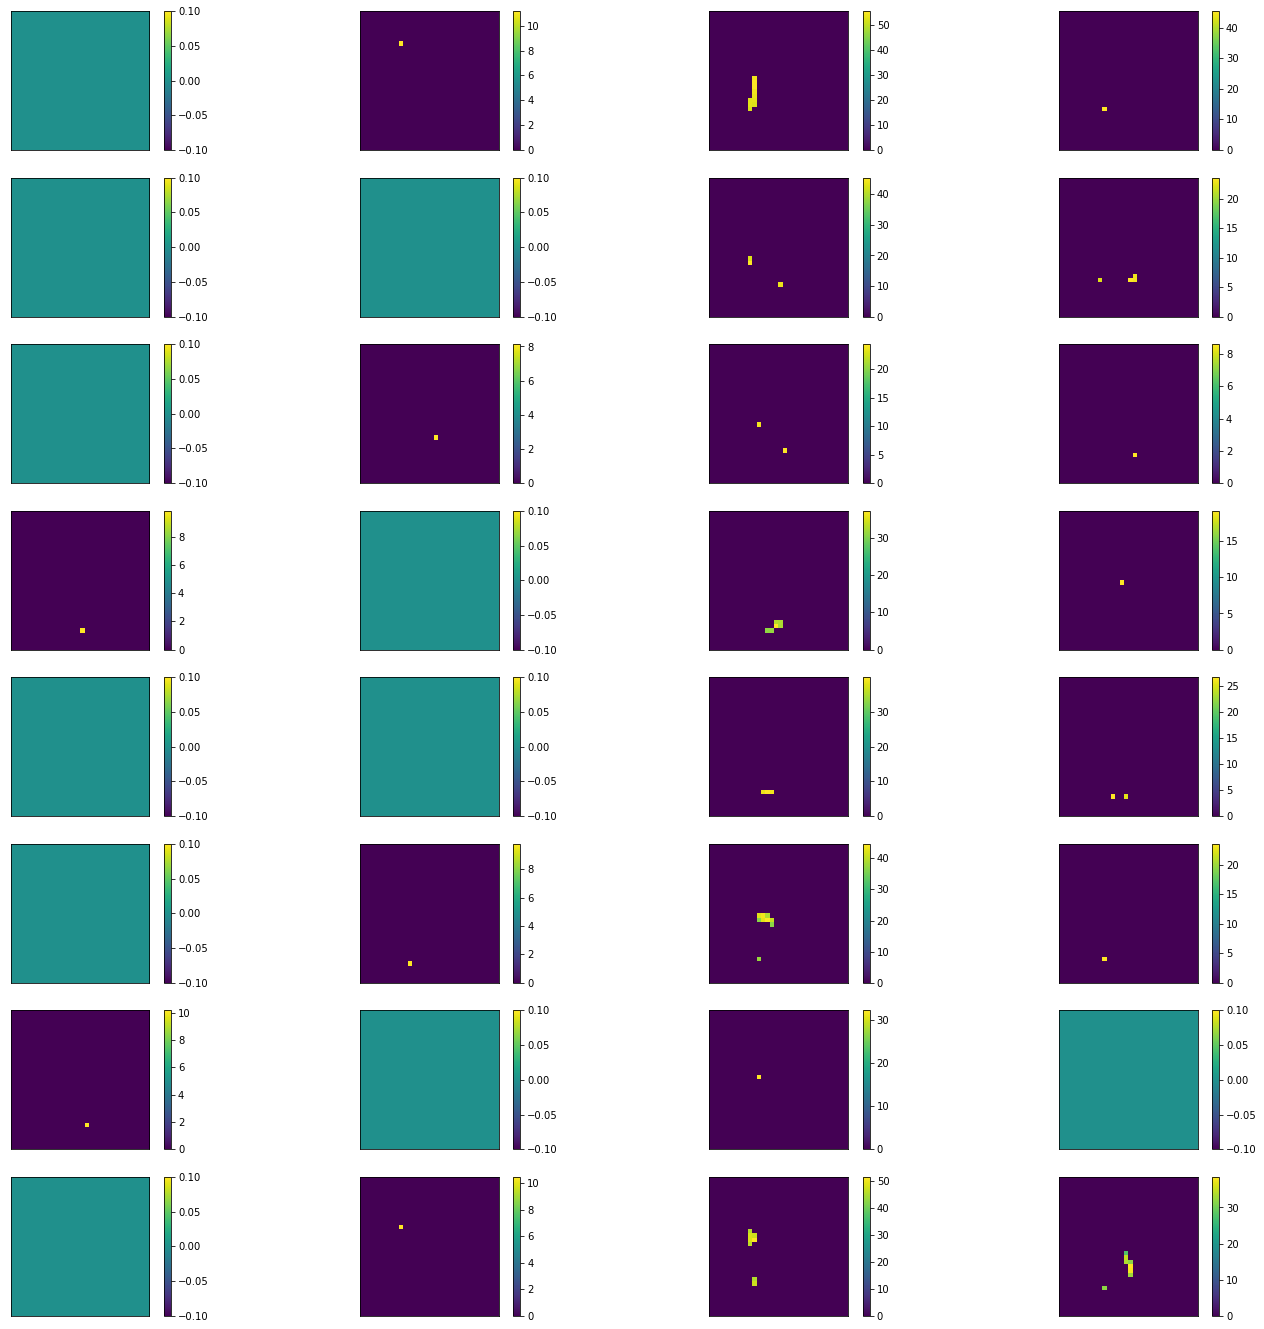

In [162]:
maxs = np.argmax(gabored, axis=0)
for r, row in enumerate(maxs):
    for c, img_idx in enumerate(row):
        v = gabored[img_idx, r, c]
        gabored[:, r, c] = 0
        gabored[img_idx, r, c] = v

        
n_k = len(gabored)
rows = n_angs
cols = n_k // rows + int((n_k % rows) > 0)
fw = 3.
print(n_k, rows, cols)
plt.figure(figsize=(fw*cols*2, fw*rows))
for i, img in enumerate(gabored):
    ax = plt.subplot(rows, cols, i + 1)
    im = ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im)

plt.show()


[[24.  15.   2.7]
 [24.  11.   2.7]
 [17.  11.   2.7]
 [ 7.   9.   0.9]]


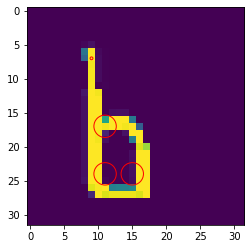

In [192]:
detected = feature.blob_dog(small.copy(), threshold=0.2, 
                            sigma_ratio=3., min_sigma=0.1, max_sigma=8)
print(detected)
plt.figure()
plt.imshow(small)
plt.scatter(detected[:, 1], detected[:, 0],
            10**detected[:, 2], facecolors='none', edgecolors='r')
plt.show()

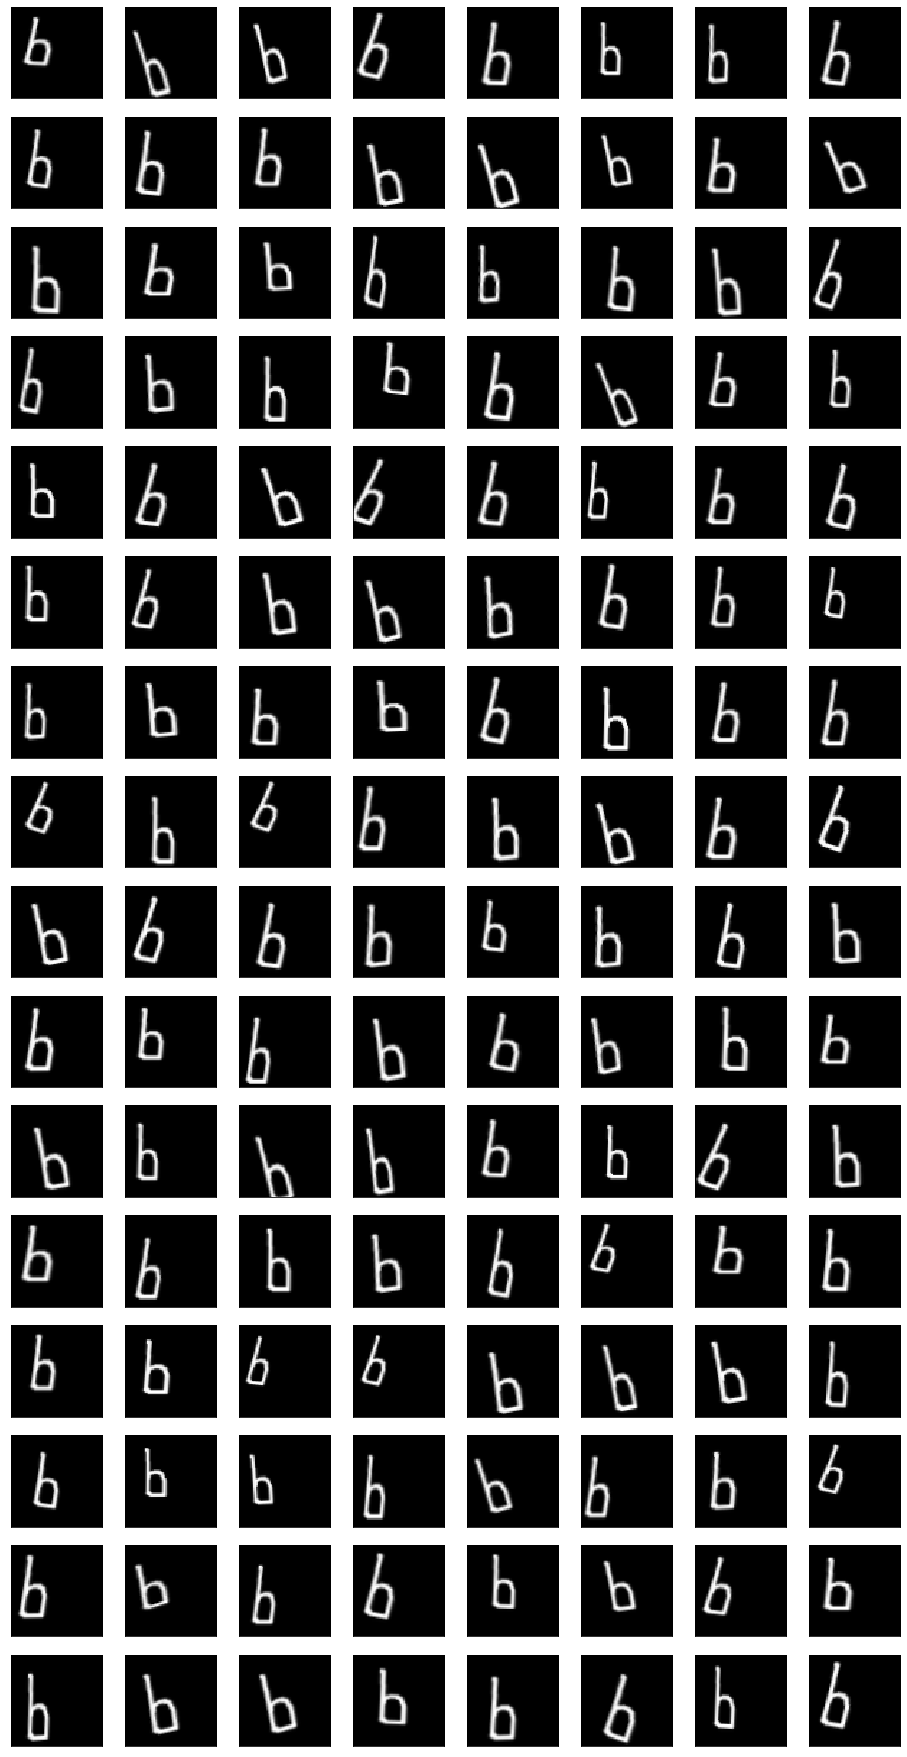

In [303]:
from scipy.signal import correlate2d

to_del = {}
td = []
corrs = np.zeros((total, total))
for i0, img0 in enumerate(aug):
    for i1, img1 in enumerate(aug):
        if i1 < i0:
            continue
        m = np.sqrt((img0**2).sum() * (img1**2).sum())
        corrs[i0, i1] = correlate2d(img0, img1, mode='valid') * (1./m)
        if i0 != i1 and corrs[i0, i1] >= 0.8:
            l = to_del.get(i0, [])
            l.append(i1)
            to_del[i0] = l
            td.append(i1)




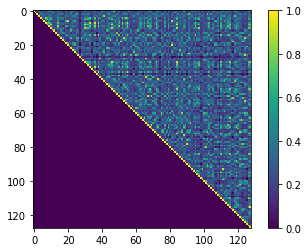

In [304]:
from pprint import pprint
from copy import copy

# pprint(to_del)
    
plt.figure()
im = plt.imshow(corrs)
plt.colorbar(im)
plt.show()

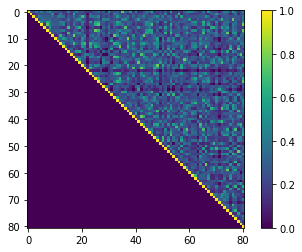

In [305]:
aug_clean = copy(aug)
for d in sorted(np.unique(td))[::-1]:
#     print(d)
    del aug_clean[d]

n = len(aug_clean)
corrs = np.zeros((n, n))
for i0, img0 in enumerate(aug_clean):
    for i1, img1 in enumerate(aug_clean):
        if i1 < i0:
            continue
        m = np.sqrt((img0**2).sum() * (img1**2).sum())
        corrs[i0, i1] = correlate2d(img0, img1, mode='valid') * (1./m)
        if i0 != i1 and corrs[i0, i1] >= 0.8:
            l = to_del.get(i0, [])
            l.append(i1)
            to_del[i0] = l
            td.append(i1)

plt.figure()
im = plt.imshow(corrs)
plt.colorbar(im)
plt.show()

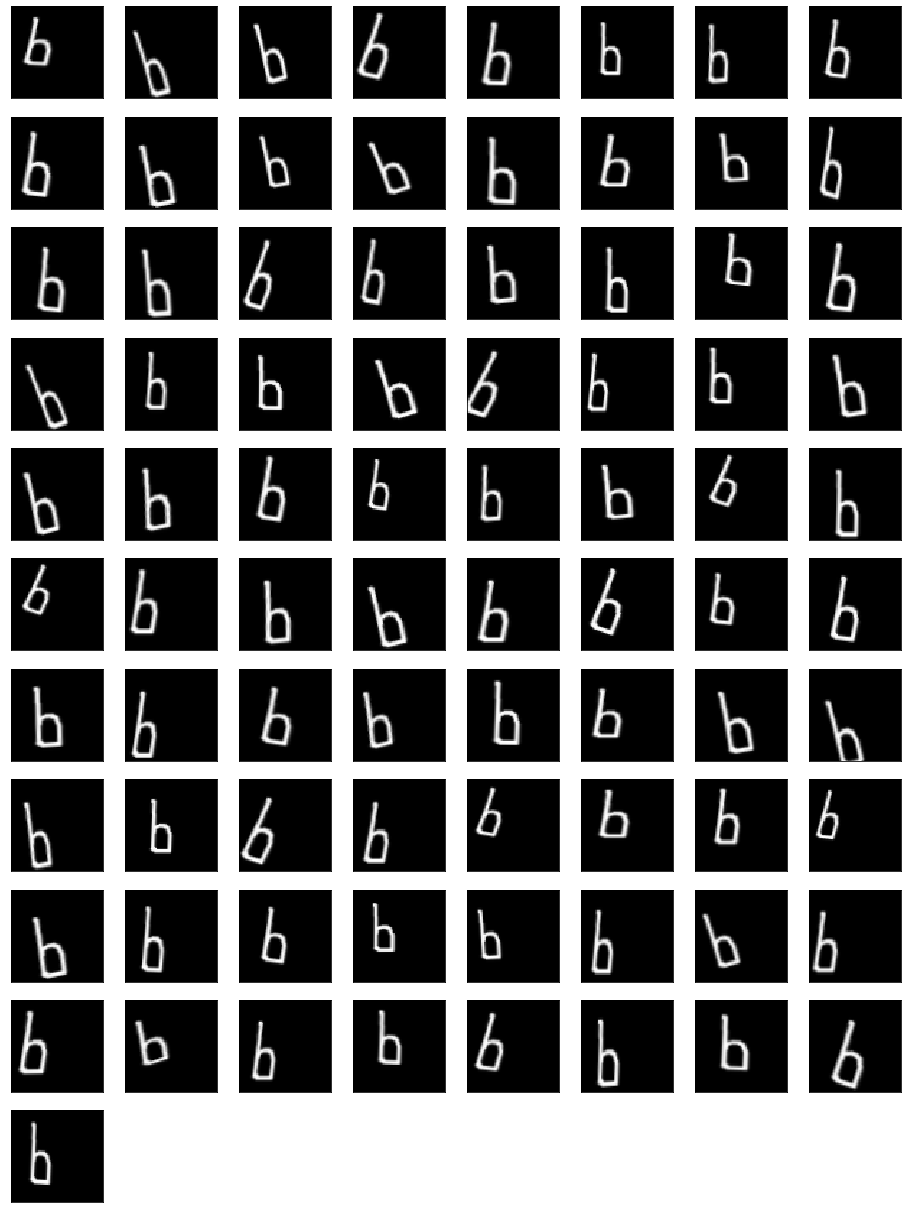

In [306]:
total = n
fw = 2.
cols = 8
rows = total // cols + int(total % cols > 0)
plt.figure(figsize=(fw*cols, fw*rows))
for i in range(total):
#     ax = plt.subplot(rows, cols, 1)
#     plt.imshow(small, cmap='gray')
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(aug_clean[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()